# Download library

In [20]:
!pip install transformers==4.28.0

In [21]:
!pip install accelerate -U

In [22]:
!pip install git+https://github.com/huggingface/accelerate

  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-06xvy8xk
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip-req-build-06xvy8xk
  Resolved https://github.com/huggingface/accelerate to commit 420743af22c34a72b19970a97ae829e31285c49e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [23]:
# !pip install huggingface_hub

# Load data and pre-processing

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
import os

os.environ['CURL_CA_BUNDLE'] = ''

In [26]:
import transformers
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertModel, BertTokenizer
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm.notebook import tqdm
from sklearn.utils import shuffle

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [27]:
valid_p = pd.read_csv("/content/drive/MyDrive/data/valid_p.csv")
valid_r = pd.read_csv('/content/drive/MyDrive/data/valid_r.csv')

test_p = pd.read_csv('/content/drive/MyDrive/data/test_p.csv')
test_r = pd.read_csv('/content/drive/MyDrive/data/test_r.csv')

train_p = pd.read_csv('/content/drive/MyDrive/data/train_p_aug.csv')
train_r = pd.read_csv('/content/drive/MyDrive/data/train_r_aug.csv')


In [28]:
P_labels=['information','design action', 'failure action','failure reasoning', 'perception']
R_labels=['introduction', 'clarification','workshop management', 'implementation', 'failure']

In [29]:
train_p = shuffle(train_p)
train_r = shuffle(train_r)

#Config

In [30]:
# params
bert_lr = 2e-5
max_length=256
epoch = 20
patience = 2
factor = 0.5
# loss function
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss_fn = nn.CrossEntropyLoss().to(device)
#batch size
batch_size = 16
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
n_train_r=len(train_r)
n_valid_r=len(valid_r)

n_train_p=len(train_p)
n_valid_p=len(valid_p)


# Model

In [31]:
class TextDataset(Dataset):

    def __init__(self, text, targets, tokenizer):

        self.targets = targets
        self.text = list(text)
        self.tokenizer = tokenizer
        self.encoded_captions = tokenizer(self.text, padding=True, truncation=True, max_length=max_length)

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        item = {
            key: torch.tensor(values[index])
            for key, values in self.encoded_captions.items()
        }

        item['target'] = self.targets[index]

        return item


def create_text_loader(df, shuffle=True):
    ds = TextDataset(text=df['text'].values,
                     targets=df['index'].values,
                     tokenizer=tokenizer)

    return DataLoader(ds,
                      batch_size=batch_size
                      ,shuffle=shuffle)



In [32]:
class Bert(nn.Module):

  def __init__(self, n_classes):
    super(Bert, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-cased')
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask,return_dict=False):
    _, pooled_output = self.bert(input_ids=input_ids,attention_mask=attention_mask, return_dict=False)
    output = self.out(pooled_output)
    return output

In [33]:
import torch
torch.cuda.empty_cache()

In [34]:
def train_epoch(model, train_dataloader, optimizer, n_train):
    model = model.train()
    losses = []
    correct_predictions = 0
    process_bar = tqdm(train_dataloader)
    for d in process_bar:
        d = {k: v.to(device) for k, v in d.items() if k != "text"}
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d['target'].to(device)

        outputs = model(input_ids=input_ids,
                        attention_mask=attention_mask)

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        optimizer.zero_grad()
        process_bar.set_postfix(train_loss=loss.item())

    return correct_predictions.double() / n_train, np.mean(losses)

def eval_model(model, val_dataloader, n_valid):
    model = model.eval()

    losses = []
    correct_predictions = 0
    process_bar = tqdm(val_dataloader)
    for d in process_bar:
        d = {k: v.to(device) for k, v in d.items() if k != "text"}
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["target"].to(device)

        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)

        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        process_bar.set_postfix(val_loss=loss.item())

    return correct_predictions.double() / n_valid, np.mean(losses)


def get_predictions(model, test_data_loader):
    model = model.eval()
    predictions = []
    real_values = []

    for d in test_data_loader:
        d = {k: v.to(device) for k, v in d.items() if k != "text"}
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["target"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        _, preds = torch.max(outputs, dim=1)

        probs = F.softmax(outputs, dim=1)

        predictions.extend(preds)
        real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    real_values = torch.stack(real_values).cpu()
    return predictions, real_values

In [35]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True')
  plt.xlabel('Predicted')

# Researcher

In [36]:
train_dataloader = create_text_loader(train_r, shuffle=True)
val_dataloader = create_text_loader(valid_r, shuffle=False)
test_dataloader = create_text_loader(test_r, shuffle=False)

In [37]:
model=Bert(5).to(device)
optimizer = AdamW(model.parameters(), lr=bert_lr,correct_bias=False)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=patience, factor=factor)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a 

In [38]:
for e in range(epoch):

  print(f'Epoch {e + 1}/{epoch}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(model,
                                      train_dataloader,
                                      optimizer,
                                      scheduler,
                                      n_train_r)
  print(f'Train loss {train_loss} accuracy {train_acc}')
  with torch.no_grad():
      val_acc, val_loss = eval_model(model, val_dataloader, n_valid_r)

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()
  scheduler.step(val_loss)

torch.save(model, '/content/drive/MyDrive/Model/R_aug_model.pt')

Epoch 1/20
----------


  0%|          | 0/237 [00:00<?, ?it/s]

Train loss 1.10068603935121 accuracy 0.5492323980942297


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.135464318593343 accuracy 0.5789473684210527

Epoch 2/20
----------


  0%|          | 0/237 [00:00<?, ?it/s]

Train loss 0.41724085089463725 accuracy 0.8549497088406565


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 1.458854430913925 accuracy 0.5964912280701754

Epoch 3/20
----------


  0%|          | 0/237 [00:00<?, ?it/s]

Train loss 0.13401814848469484 accuracy 0.9592376919004765


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 2.0610691865285236 accuracy 0.6140350877192982

Epoch 4/20
----------


  0%|          | 0/237 [00:00<?, ?it/s]

Train loss 0.05626458569870916 accuracy 0.9838538909475913


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 2.3538543542226154 accuracy 0.6228070175438596

Epoch 5/20
----------


  0%|          | 0/237 [00:00<?, ?it/s]

Train loss 0.01348132322719694 accuracy 0.9965590259396506


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 2.534999652703603 accuracy 0.6184210526315789

Epoch 6/20
----------


  0%|          | 0/237 [00:00<?, ?it/s]

Train loss 0.009551758774043403 accuracy 0.9973530968766544


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 2.5917791684468585 accuracy 0.6271929824561403

Epoch 7/20
----------


  0%|          | 0/237 [00:00<?, ?it/s]

Train loss 0.0031627475713597777 accuracy 0.9994706193753309


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 2.724060082435608 accuracy 0.6228070175438596

Epoch 8/20
----------


  0%|          | 0/237 [00:00<?, ?it/s]

Train loss 0.004693192432910589 accuracy 0.9989412387506618


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 2.727524924278259 accuracy 0.6052631578947368

Epoch 9/20
----------


  0%|          | 0/237 [00:00<?, ?it/s]

Train loss 0.002453659619054883 accuracy 0.9994706193753309


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 2.7910275141398113 accuracy 0.6008771929824561

Epoch 10/20
----------


  0%|          | 0/237 [00:00<?, ?it/s]

Train loss 0.003000600979897245 accuracy 0.9992059290629963


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 2.826207915941874 accuracy 0.6096491228070176

Epoch 11/20
----------


  0%|          | 0/237 [00:00<?, ?it/s]

Train loss 0.0016656893646007577 accuracy 0.9994706193753309


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 2.8290316661198935 accuracy 0.6140350877192982

Epoch 12/20
----------


  0%|          | 0/237 [00:00<?, ?it/s]

Train loss 0.0020950394285325045 accuracy 0.9992059290629963


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 2.8351580063501993 accuracy 0.6096491228070176

Epoch 13/20
----------


  0%|          | 0/237 [00:00<?, ?it/s]

Train loss 0.002095398626657191 accuracy 0.9994706193753309


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 2.825594258308411 accuracy 0.6140350877192982

Epoch 14/20
----------


  0%|          | 0/237 [00:00<?, ?it/s]

Train loss 0.0017958249859801663 accuracy 0.9994706193753309


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 2.841113034884135 accuracy 0.6140350877192982

Epoch 15/20
----------


  0%|          | 0/237 [00:00<?, ?it/s]

Train loss 0.001866104592370726 accuracy 0.9994706193753309


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 2.8553810437520344 accuracy 0.6184210526315789

Epoch 16/20
----------


  0%|          | 0/237 [00:00<?, ?it/s]

Train loss 0.001872875543450249 accuracy 0.9994706193753309


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 2.871607748667399 accuracy 0.6184210526315789

Epoch 17/20
----------


  0%|          | 0/237 [00:00<?, ?it/s]

Train loss 0.00171698811380507 accuracy 0.9994706193753309


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 2.883495537439982 accuracy 0.6184210526315789

Epoch 18/20
----------


  0%|          | 0/237 [00:00<?, ?it/s]

Train loss 0.001699796706002858 accuracy 0.9994706193753309


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 2.8894211212793985 accuracy 0.6140350877192982

Epoch 19/20
----------


  0%|          | 0/237 [00:00<?, ?it/s]

Train loss 0.0018237920635539983 accuracy 0.9994706193753309


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 2.895070958137512 accuracy 0.6140350877192982

Epoch 20/20
----------


  0%|          | 0/237 [00:00<?, ?it/s]

Train loss 0.0015490526946657928 accuracy 0.9994706193753309


  0%|          | 0/15 [00:00<?, ?it/s]

Val loss 2.90193026860555 accuracy 0.6140350877192982



In [39]:
with torch.no_grad():
  y_pred, y_test=get_predictions(model, test_dataloader)

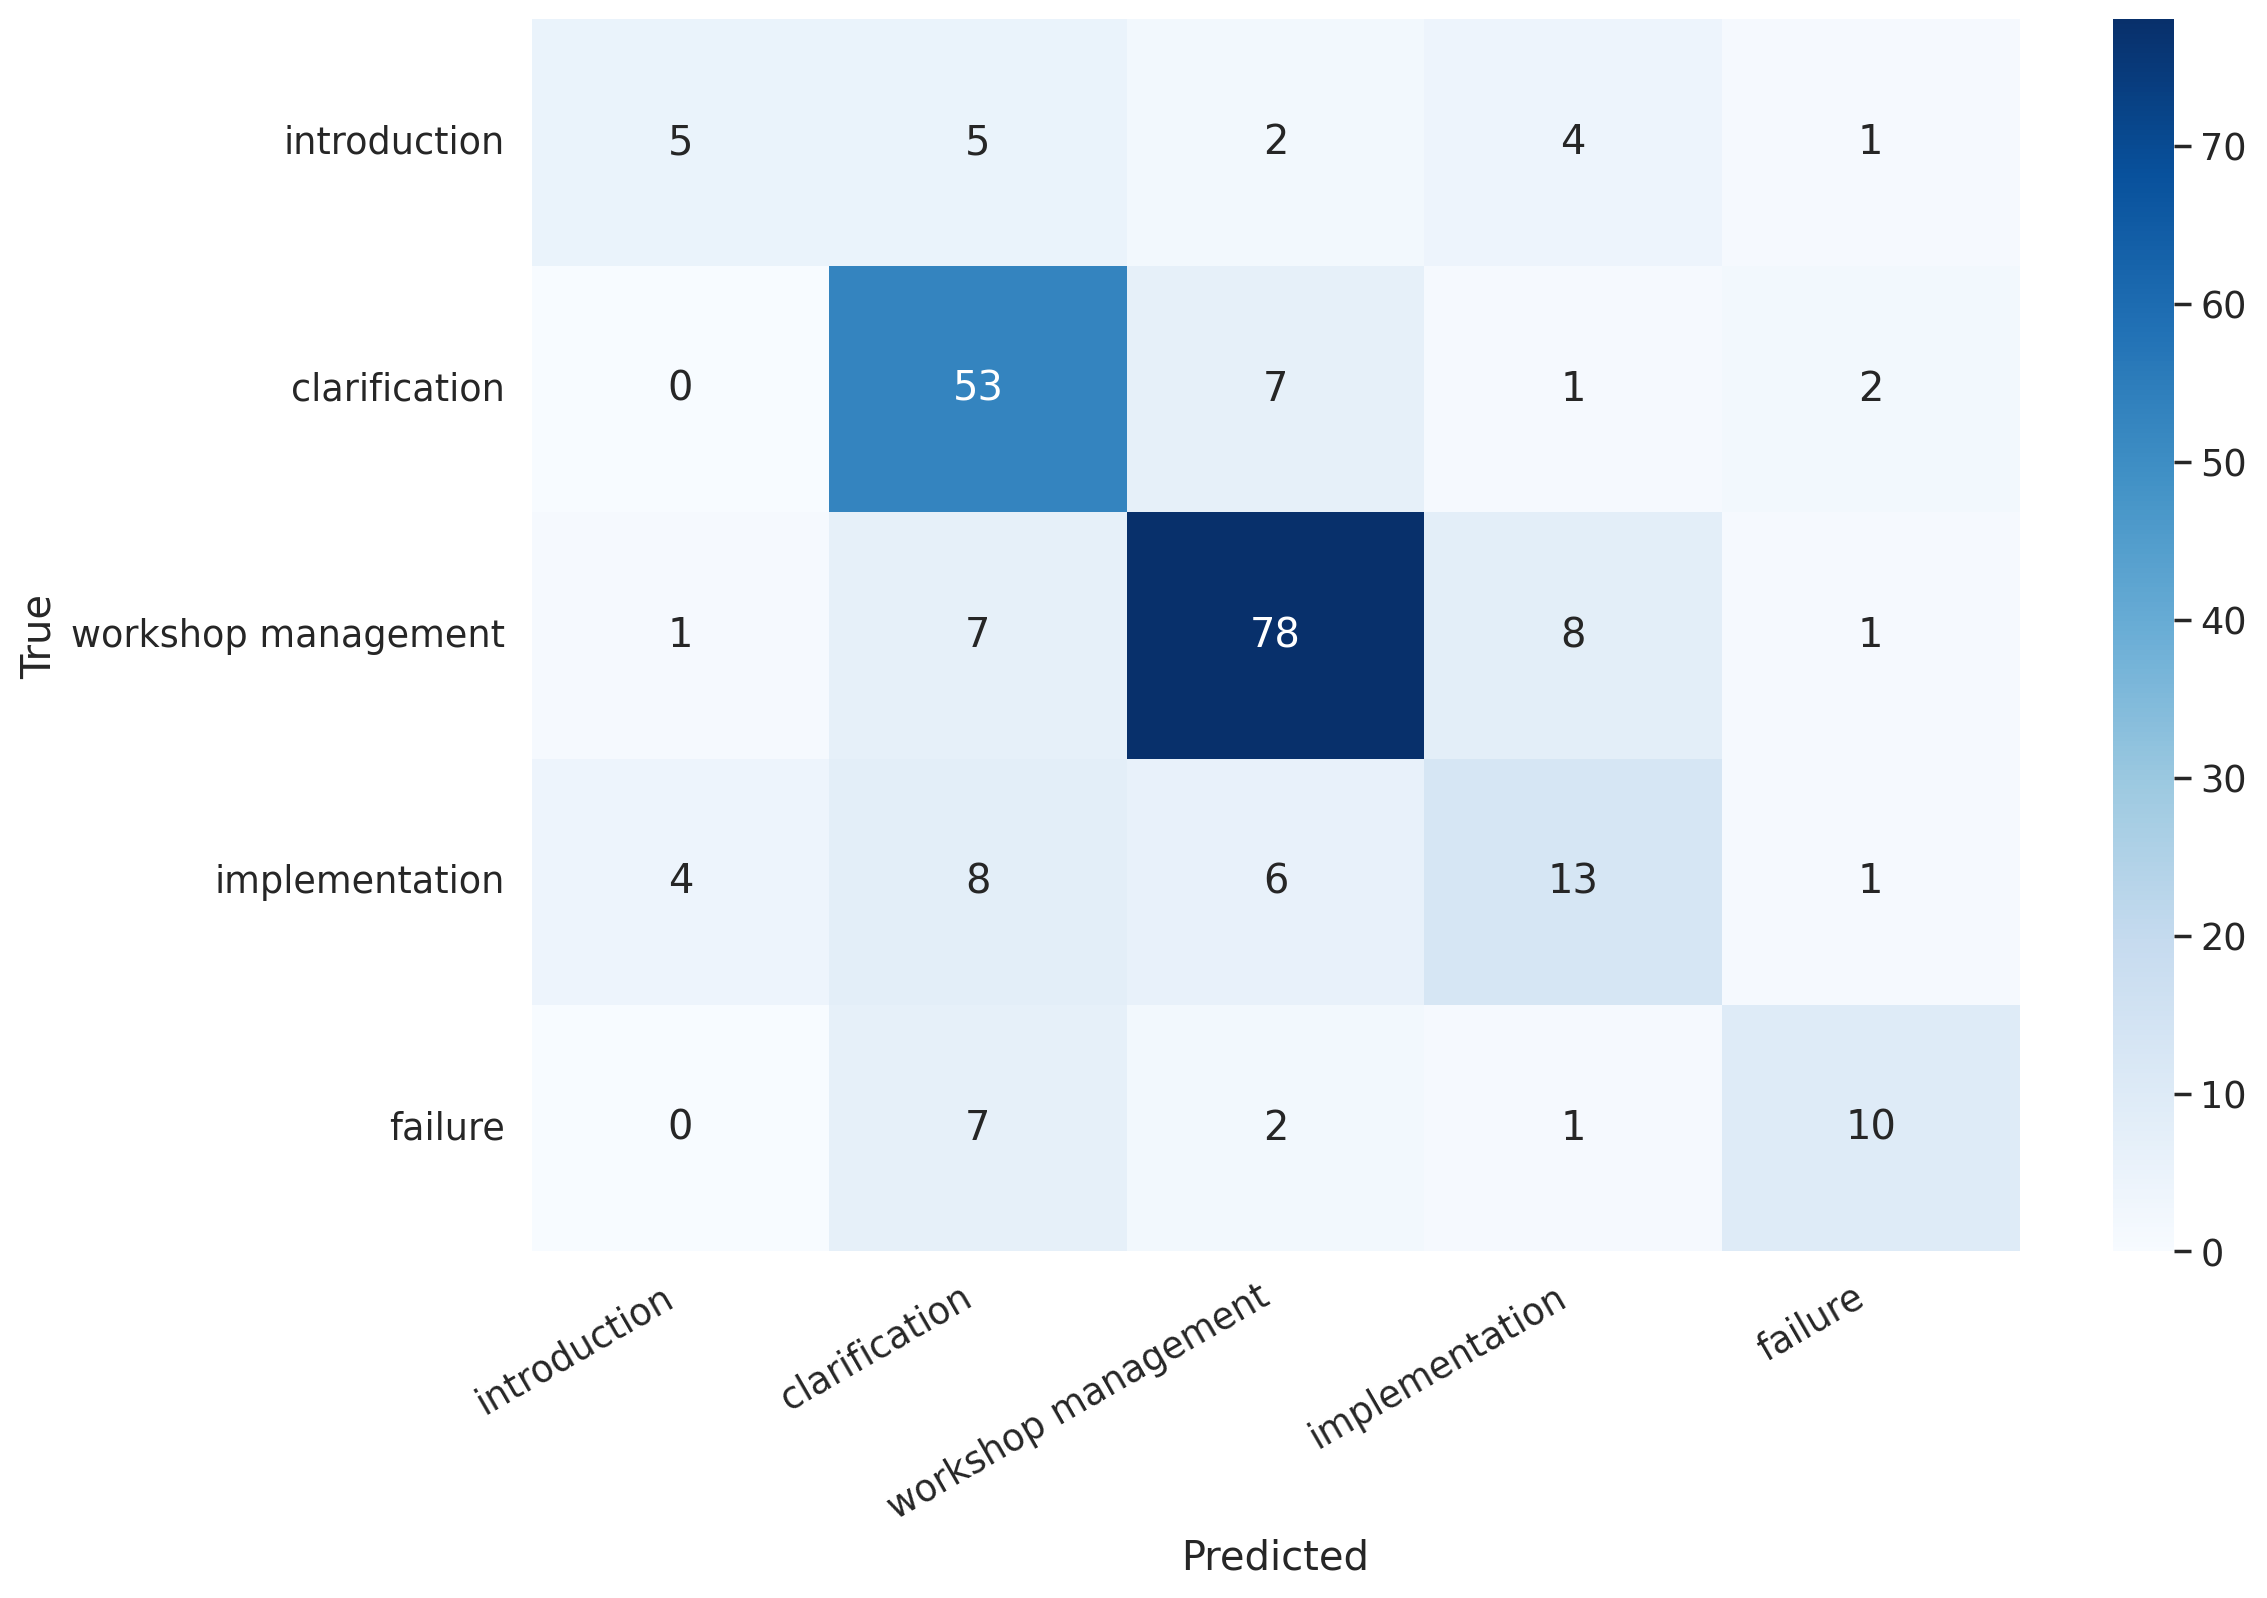

In [40]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=R_labels, columns=R_labels)
show_confusion_matrix(df_cm)

In [41]:
print(classification_report(y_test, y_pred, target_names=R_labels))

                     precision    recall  f1-score   support

       introduction       0.50      0.29      0.37        17
      clarification       0.66      0.84      0.74        63
workshop management       0.82      0.82      0.82        95
     implementation       0.48      0.41      0.44        32
            failure       0.67      0.50      0.57        20

           accuracy                           0.70       227
          macro avg       0.63      0.57      0.59       227
       weighted avg       0.69      0.70      0.69       227



# Participant

In [49]:
train_dataloader_p = create_text_loader(train_p, shuffle=True)
val_dataloader_p = create_text_loader(valid_p, shuffle=False)
test_dataloader_p = create_text_loader(test_p, shuffle=False)

In [50]:
model=Bert(5).to(device)
optimizer = AdamW(model.parameters(), lr=bert_lr,correct_bias=False)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=patience, factor=factor)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a 

In [51]:
for e in range(epoch):

  print(f'Epoch {e + 1}/{epoch}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(model,
                                      train_dataloader_p,
                                      optimizer,
                                      n_train_p)
  print(f'Train loss {train_loss} accuracy {train_acc}')
  with torch.no_grad():
      val_acc, val_loss = eval_model(model, val_dataloader_p, n_valid_p)

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()
  scheduler.step(val_loss)

torch.save(model, '/content/drive/MyDrive/Model/P_aug_model.pt')

Epoch 1/20
----------


  0%|          | 0/136 [00:00<?, ?it/s]

Train loss 1.2556155052255182 accuracy 0.4702627939142462


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.4218025108178456 accuracy 0.47802197802197804

Epoch 2/20
----------


  0%|          | 0/136 [00:00<?, ?it/s]

Train loss 0.6424904759315884 accuracy 0.7524204702627939


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 1.6480650107065837 accuracy 0.45054945054945056

Epoch 3/20
----------


  0%|          | 0/136 [00:00<?, ?it/s]

Train loss 0.28278738076743837 accuracy 0.9064084831719686


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 2.062151163816452 accuracy 0.5

Epoch 4/20
----------


  0%|          | 0/136 [00:00<?, ?it/s]

Train loss 0.11754462491508628 accuracy 0.9640387275242047


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 2.6293186644713082 accuracy 0.4835164835164836

Epoch 5/20
----------


  0%|          | 0/136 [00:00<?, ?it/s]

Train loss 0.029066169221871805 accuracy 0.9921622867680959


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 2.9967544277509055 accuracy 0.4835164835164836

Epoch 6/20
----------


  0%|          | 0/136 [00:00<?, ?it/s]

Train loss 0.010356856762133675 accuracy 0.9972337482710927


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 3.1935096780459085 accuracy 0.48901098901098905

Epoch 7/20
----------


  0%|          | 0/136 [00:00<?, ?it/s]

Train loss 0.00560615909874768 accuracy 0.9990779160903642


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 3.3447083632151284 accuracy 0.48901098901098905

Epoch 8/20
----------


  0%|          | 0/136 [00:00<?, ?it/s]

Train loss 0.004959464622087954 accuracy 0.9990779160903642


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 3.3843401273091636 accuracy 0.48901098901098905

Epoch 9/20
----------


  0%|          | 0/136 [00:00<?, ?it/s]

Train loss 0.0021598883204740774 accuracy 0.9990779160903642


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 3.4245516260464988 accuracy 0.5

Epoch 10/20
----------


  0%|          | 0/136 [00:00<?, ?it/s]

Train loss 0.0023821542420003373 accuracy 0.9990779160903642


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 3.47213747104009 accuracy 0.5054945054945056

Epoch 11/20
----------


  0%|          | 0/136 [00:00<?, ?it/s]

Train loss 0.004053386700166704 accuracy 0.9990779160903642


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 3.4975446859995523 accuracy 0.5054945054945056

Epoch 12/20
----------


  0%|          | 0/136 [00:00<?, ?it/s]

Train loss 0.002640045515898451 accuracy 0.9995389580451821


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 3.509996692339579 accuracy 0.5054945054945056

Epoch 13/20
----------


  0%|          | 0/136 [00:00<?, ?it/s]

Train loss 0.0026484257199198883 accuracy 0.9995389580451821


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 3.5258655349413552 accuracy 0.5109890109890111

Epoch 14/20
----------


  0%|          | 0/136 [00:00<?, ?it/s]

Train loss 0.0023873284290483058 accuracy 0.9986168741355463


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 3.5388181606928506 accuracy 0.5109890109890111

Epoch 15/20
----------


  0%|          | 0/136 [00:00<?, ?it/s]

Train loss 0.001987793549821671 accuracy 0.9995389580451821


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 3.554113030433655 accuracy 0.5054945054945056

Epoch 16/20
----------


  0%|          | 0/136 [00:00<?, ?it/s]

Train loss 0.002751725516324822 accuracy 0.9990779160903642


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 3.56456051270167 accuracy 0.5054945054945056

Epoch 17/20
----------


  0%|          | 0/136 [00:00<?, ?it/s]

Train loss 0.0024708351685309455 accuracy 0.9995389580451821


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 3.5648733973503113 accuracy 0.5109890109890111

Epoch 18/20
----------


  0%|          | 0/136 [00:00<?, ?it/s]

Train loss 0.0021483647722240727 accuracy 0.9995389580451821


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 3.5771233638127646 accuracy 0.5054945054945056

Epoch 19/20
----------


  0%|          | 0/136 [00:00<?, ?it/s]

Train loss 0.0027416735144523796 accuracy 0.9995389580451821


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 3.579833209514618 accuracy 0.5054945054945056

Epoch 20/20
----------


  0%|          | 0/136 [00:00<?, ?it/s]

Train loss 0.002796880531925982 accuracy 0.9990779160903642


  0%|          | 0/12 [00:00<?, ?it/s]

Val loss 3.582112491130829 accuracy 0.5054945054945056



In [52]:
with torch.no_grad():
  y_pred, y_test=get_predictions(model, test_dataloader_p)

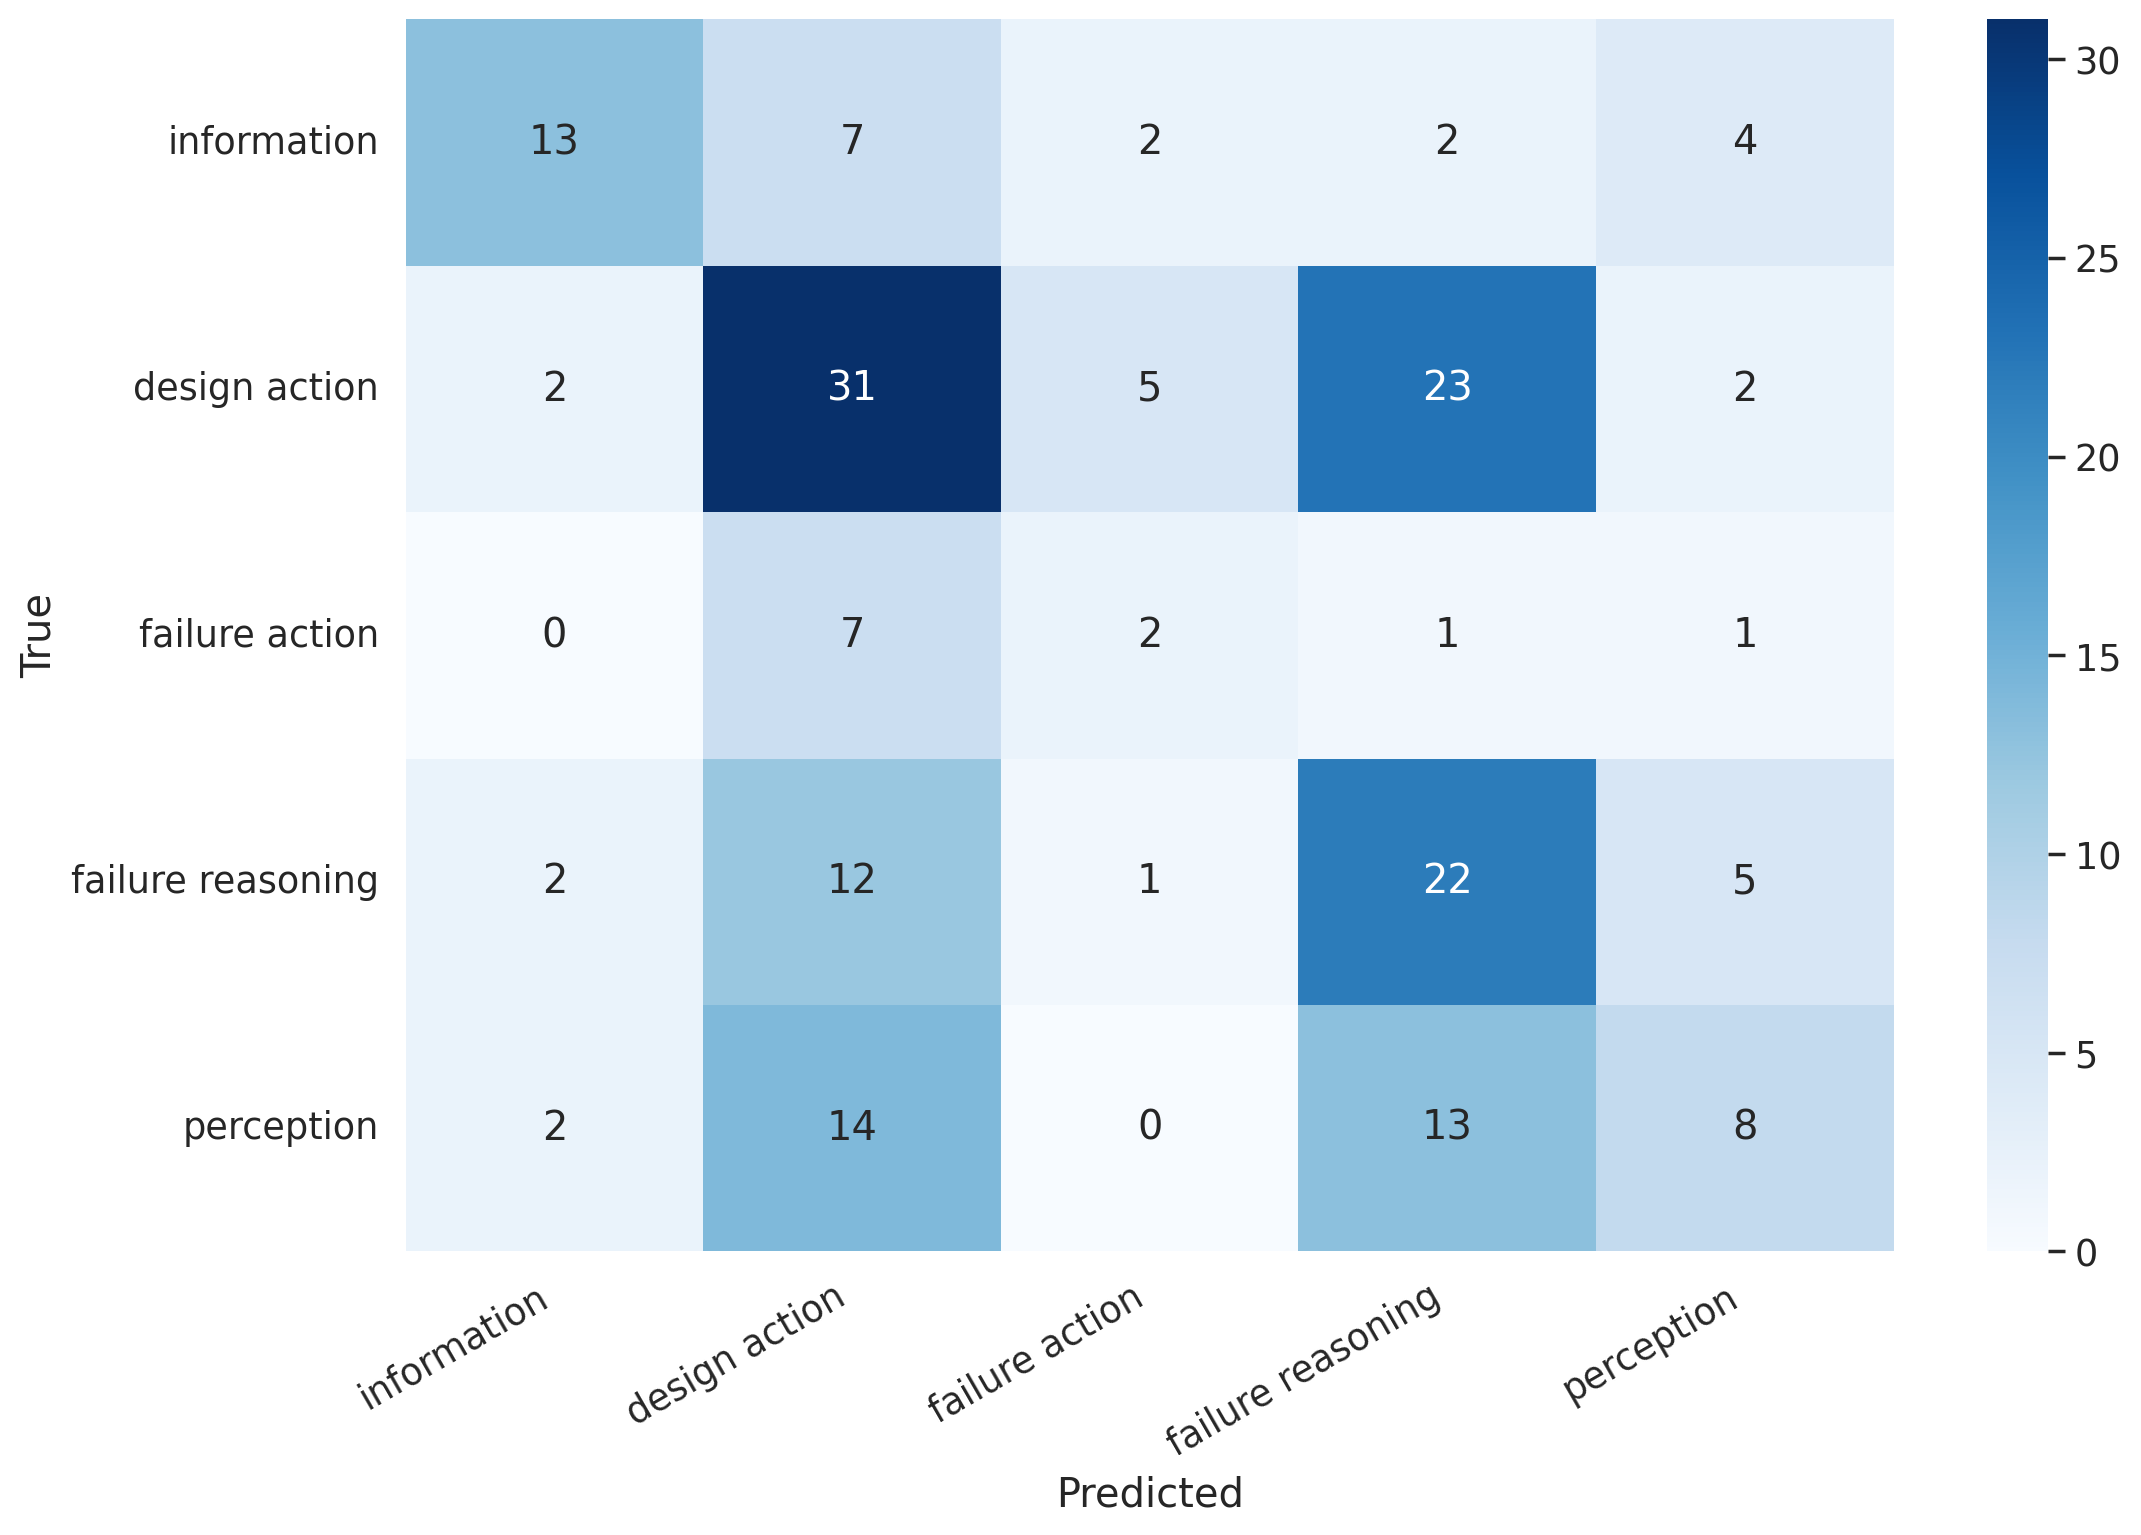

In [53]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=P_labels, columns=P_labels)
show_confusion_matrix(df_cm)

In [54]:
print(classification_report(y_test, y_pred, target_names=P_labels))

                   precision    recall  f1-score   support

      information       0.68      0.46      0.55        28
    design action       0.44      0.49      0.46        63
   failure action       0.20      0.18      0.19        11
failure reasoning       0.36      0.52      0.43        42
       perception       0.40      0.22      0.28        37

         accuracy                           0.42       181
        macro avg       0.42      0.38      0.38       181
     weighted avg       0.44      0.42      0.41       181

